In [2]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

tf.random.set_seed(101)

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'
# base_dir = 'base_dir'
# train_dir = os.path.join(base_dir, 'train_dir')
# val_dir = os.path.join(base_dir, 'val_dir')

# df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')

# # this will tell us how many images are associated with each lesion_id
# df = df_data.groupby('lesion_id').count()

# # now we filter out lesion_id's that have only one image associated with it
# df = df[df['image_id'] == 1]
# df.reset_index(inplace=True)


# # here we identify lesion_id's that have duplicate images and those that have only
# # one image.

# def identify_duplicates(x):
#     unique_list = list(df['lesion_id'])
    
#     if x in unique_list:
#         return 'no_duplicates'
#     else:
#         return 'has_duplicates'
    
# # create a new colum that is a copy of the lesion_id column
# df_data['duplicates'] = df_data['lesion_id']
# # apply the function to this new column
# df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

# # now we filter out images that don't have duplicates
# df = df_data[df_data['duplicates'] == 'no_duplicates']

# # now we create a val set using df because we are sure that none of these images
# # have augmented duplicates in the train set
# y = df['dx']

# _, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

# # This set will be df_data excluding all rows that are in the val set

# # This function identifies if an image is part of the train
# # or val set.
# def identify_val_rows(x):
#     # create a list of all the lesion_id's in the val set
#     val_list = list(df_val['image_id'])
    
#     if str(x) in val_list:
#         return 'val'
#     else:
#         return 'train'

# # identify train and val rows

# # create a new colum that is a copy of the image_id column
# df_data['train_or_val'] = df_data['image_id']
# # apply the function to this new column
# df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# # filter out train rows
# df_train = df_data[df_data['train_or_val'] == 'train']


# print(len(df_train))
# print(len(df_val))

9077
938


In [3]:
# for v2

dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'
base_dir = 'base_dir_v2'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')


#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(9013, 7)
(1002, 7)


In [5]:
train_path = base_dir + '/train_dir'
valid_path = base_dir + '/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

class_weights = {
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

Found 38704 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [13]:
# create a copy of a mobilenet model
mobile = tf.keras.applications.mobilenet.MobileNet()

mobile.summary()
print(type(mobile.layers))
# How many layers does MobileNet have?
print(len(mobile.layers))

# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [14]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenet_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30
901/902 [============================>.] - ETA: 0s - loss: 1.7836 - categorical_accuracy: 0.5124 - top_2_accuracy: 0.7075 - top_3_accuracy: 0.8334
Epoch 00001: val_categorical_accuracy improved from -inf to 0.67365, saving model to mobilenet_model.h5
902/902 [==============================] - 129s 143ms/step - loss: 1.7827 - categorical_accuracy: 0.5125 - top_2_accuracy: 0.7078 - top_3_accuracy: 0.8335 - val_loss: 1.3190 - val_categorical_accuracy: 0.6737 - val_top_2_accuracy: 0.7685 - val_top_3_accuracy: 0.8533
Epoch 2/30
901/902 [============================>.] - ETA: 0s - loss: 1.3056 - categorical_accuracy: 0.5996 - top_2_accuracy: 0.8021 - top_3_accuracy: 0.9084
Epoch 00002: val_categorical_accuracy did not improve from 0.67365
902/902 [==============================] - 114s 126ms/step - loss: 1.3053 - categorical_accuracy: 0.5998 - top_2_accuracy: 0.8021 - top_3_accuracy: 0.9084 - val_loss: 2.0881 - val_categorical_accuracy: 0.3353 - val_top_2_accuracy: 0.6657 - val_to

Epoch 17/30
901/902 [============================>.] - ETA: 0s - loss: 0.3760 - categorical_accuracy: 0.8816 - top_2_accuracy: 0.9760 - top_3_accuracy: 0.9954
Epoch 00017: val_categorical_accuracy did not improve from 0.72754
902/902 [==============================] - 111s 123ms/step - loss: 0.3757 - categorical_accuracy: 0.8817 - top_2_accuracy: 0.9760 - top_3_accuracy: 0.9955 - val_loss: 1.1275 - val_categorical_accuracy: 0.6587 - val_top_2_accuracy: 0.8563 - val_top_3_accuracy: 0.9351
Epoch 18/30
901/902 [============================>.] - ETA: 0s - loss: 0.3643 - categorical_accuracy: 0.8893 - top_2_accuracy: 0.9740 - top_3_accuracy: 0.9942
Epoch 00018: val_categorical_accuracy did not improve from 0.72754

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
902/902 [==============================] - 110s 122ms/step - loss: 0.3641 - categorical_accuracy: 0.8894 - top_2_accuracy: 0.9740 - top_3_accuracy: 0.9942 - val_loss: 1.1924 - val_categorical_accuracy

In [15]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.235391979385192
val_cat_acc: 0.6467066
val_top_2_acc: 0.8512974
val_top_3_acc: 0.9331337


In [16]:
# Here the best epoch will be used.

model.load_weights('mobilenet_model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.9255998704817164
val_cat_acc: 0.7275449
val_top_2_acc: 0.86127746
val_top_3_acc: 0.91117764


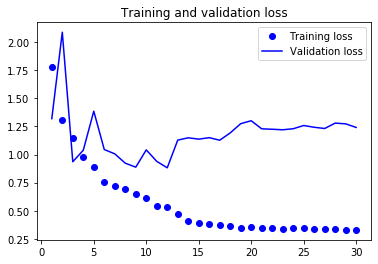

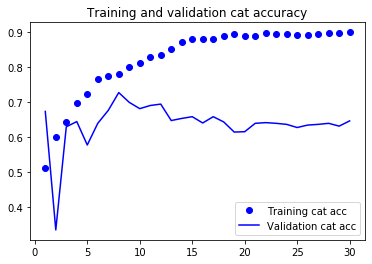

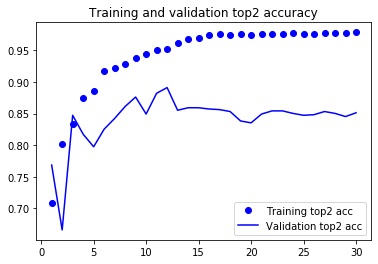

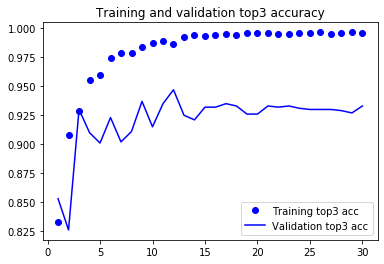

In [17]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [25]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
mobilev2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               weights='imagenet')
mobilev2.summary()
print(len(mobilev2.layers))

x = mobilev2.layers[-2].output
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=mobilev2.input, outputs=predictions)

for layer in model.layers[:-31]:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [27]:
base_learning_rate = 0.0001

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenetv2_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
901/902 [============================>.] - ETA: 0s - loss: 1.7232 - categorical_accuracy: 0.4577 - top_2_accuracy: 0.6667 - top_3_accuracy: 0.8024
Epoch 00001: val_categorical_accuracy improved from -inf to 0.11078, saving model to mobilenetv2_model.h5
902/902 [==============================] - 153s 169ms/step - loss: 1.7225 - categorical_accuracy: 0.4580 - top_2_accuracy: 0.6670 - top_3_accuracy: 0.8025 - val_loss: 14.0285 - val_categorical_accuracy: 0.1108 - val_top_2_accuracy: 0.2186 - val_top_3_accuracy: 0.3273
Epoch 2/30
901/902 [============================>.] - ETA: 0s - loss: 1.3300 - categorical_accuracy: 0.5834 - top_2_accuracy: 0.7806 - top_3_accuracy: 0.8936
Epoch 00002: val_categorical_accuracy did not improve from 0.11078
902/902 [==============================] - 152s 169ms/step - loss: 1.3299 - categorical_accuracy: 0.5835 - top_2_accuracy: 0.7806 - top_3_accuracy: 0.8935 - val_loss: 11.6178 - val_categorical_accuracy: 0.1048 - val_top_2_accuracy: 0.1806 - va

Epoch 17/30
901/902 [============================>.] - ETA: 0s - loss: 0.5719 - categorical_accuracy: 0.8171 - top_2_accuracy: 0.9504 - top_3_accuracy: 0.9873
Epoch 00017: val_categorical_accuracy improved from 0.65868 to 0.67465, saving model to mobilenetv2_model.h5
902/902 [==============================] - 154s 171ms/step - loss: 0.5715 - categorical_accuracy: 0.8173 - top_2_accuracy: 0.9504 - top_3_accuracy: 0.9874 - val_loss: 1.1201 - val_categorical_accuracy: 0.6747 - val_top_2_accuracy: 0.7974 - val_top_3_accuracy: 0.8743
Epoch 18/30
901/902 [============================>.] - ETA: 0s - loss: 0.5540 - categorical_accuracy: 0.8296 - top_2_accuracy: 0.9514 - top_3_accuracy: 0.9867
Epoch 00018: val_categorical_accuracy did not improve from 0.67465
902/902 [==============================] - 154s 170ms/step - loss: 0.5538 - categorical_accuracy: 0.8297 - top_2_accuracy: 0.9514 - top_3_accuracy: 0.9867 - val_loss: 1.1836 - val_categorical_accuracy: 0.6557 - val_top_2_accuracy: 0.7924 -

val_loss: 2.487527050557359
val_cat_acc: 0.67165667
val_top_2_acc: 0.72954094
val_top_3_acc: 0.8003992


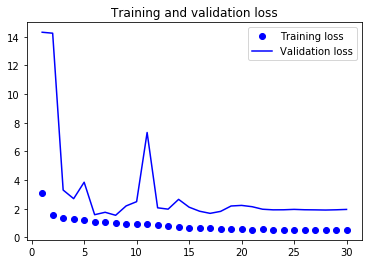

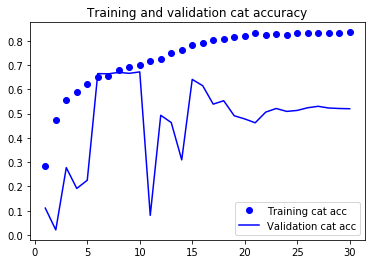

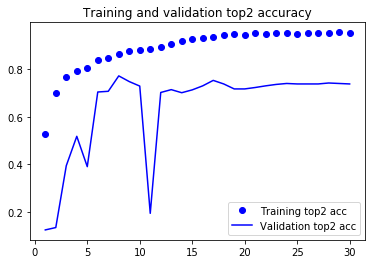

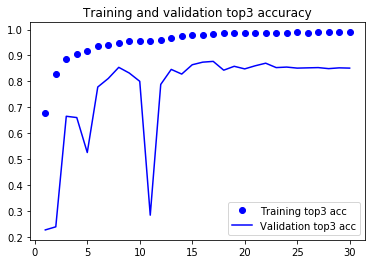

In [20]:
# Here the best epoch will be used.

model.load_weights(filepath)

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [21]:
from MobileNet_V3 import build_mobilenet_v3
model = build_mobilenet_v3(input_size=224, num_classes=7, model_type='small', pooling_type='avg', include_top=True)

print(model.summary())
print(len(model.layers))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 112, 112, 16) 432         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 112, 112, 16) 64          conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 112, 112, 16) 0           batch_normalization_35[0][0]     
____________________________________________________________________________________________

In [22]:
base_learning_rate = 0.0001

model.compile(Adam(lr=0.1), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenetv3_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint]
history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=80, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/80
901/902 [============================>.] - ETA: 0s - loss: 18.6794 - categorical_accuracy: 0.1542 - top_2_accuracy: 0.9976 - top_3_accuracy: 0.9983
Epoch 00001: val_categorical_accuracy improved from -inf to 0.10978, saving model to mobilenetv3_model.h5
902/902 [==============================] - 243s 269ms/step - loss: 18.6802 - categorical_accuracy: 0.1542 - top_2_accuracy: 0.9976 - top_3_accuracy: 0.9983 - val_loss: 14.2988 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 2/80
901/902 [============================>.] - ETA: 0s - loss: 18.4723 - categorical_accuracy: 0.1523 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00002: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 243s 269ms/step - loss: 18.4661 - categorical_accuracy: 0.1523 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.2988 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 

Epoch 18/80
901/902 [============================>.] - ETA: 0s - loss: 18.5948 - categorical_accuracy: 0.1488 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00018: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 242s 269ms/step - loss: 18.5921 - categorical_accuracy: 0.1489 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 19/80
901/902 [============================>.] - ETA: 0s - loss: 18.3113 - categorical_accuracy: 0.1560 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00019: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 243s 270ms/step - loss: 18.3089 - categorical_accuracy: 0.1563 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 20

Epoch 35/80
901/902 [============================>.] - ETA: 0s - loss: 18.4938 - categorical_accuracy: 0.1504 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00035: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 244s 271ms/step - loss: 18.5001 - categorical_accuracy: 0.1505 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 36/80
901/902 [============================>.] - ETA: 0s - loss: 18.8247 - categorical_accuracy: 0.1464 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00036: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 244s 270ms/step - loss: 18.8217 - categorical_accuracy: 0.1465 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 37

Epoch 52/80
901/902 [============================>.] - ETA: 0s - loss: 18.3041 - categorical_accuracy: 0.1567 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00052: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 244s 270ms/step - loss: 18.3071 - categorical_accuracy: 0.1567 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 53/80
901/902 [============================>.] - ETA: 0s - loss: 18.4795 - categorical_accuracy: 0.1538 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00053: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 242s 268ms/step - loss: 18.4768 - categorical_accuracy: 0.1539 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 54

Epoch 69/80
901/902 [============================>.] - ETA: 0s - loss: 18.3900 - categorical_accuracy: 0.1552 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00069: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 241s 267ms/step - loss: 18.3964 - categorical_accuracy: 0.1551 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.2988 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 70/80
901/902 [============================>.] - ETA: 0s - loss: 18.4956 - categorical_accuracy: 0.1602 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00070: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 244s 270ms/step - loss: 18.4947 - categorical_accuracy: 0.1601 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 14.3627 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 71

val_loss: 14.34864382044284
val_cat_acc: 0.10978044
val_top_2_acc: 1.0
val_top_3_acc: 1.0


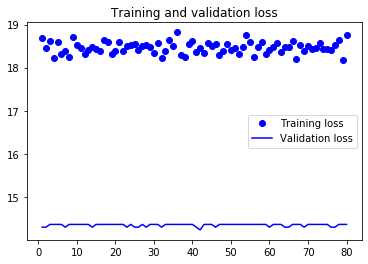

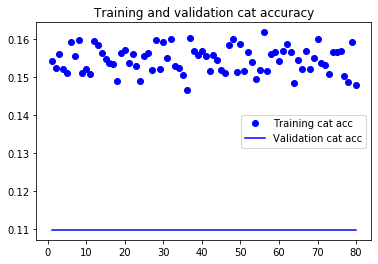

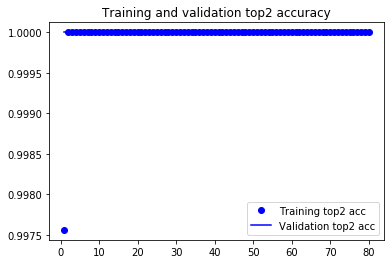

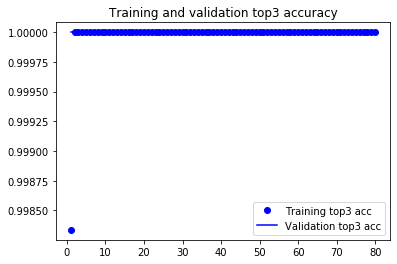

In [23]:
# Here the best epoch will be used.

model.load_weights(filepath)

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()